In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install librosa tensorflow numpy pandas scikit-learn matplotlib

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import librosa

# MFCC Extraction Function
def extract_mfcc_2d(file_path, n_mfcc=40, segment_duration=3, overlap=0.5, n_fft=2048, hop_length=512):
    audio, sr = librosa.load(file_path, sr=None)
    segment_samples = int(segment_duration * sr)
    step_samples = int(segment_samples * (1 - overlap))
    mfcc_features = []

    for start in range(0, len(audio) - segment_samples + 1, step_samples):
        segment = audio[start:start + segment_samples]
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T  # (time_steps, n_mfcc)
        mfcc_features.append(mfcc)

    return mfcc_features

#Load Metadata and Remove Duplicates
metadata = pd.read_csv("/content/drive/MyDrive/Data/features_30_sec.csv")
metadata = metadata.drop_duplicates(subset=['filename', 'label'])
genres = metadata['label'].unique()

X, y, file_names = [], [], []

for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Extracting MFCCs"):
    file_path = os.path.join("/content/drive/MyDrive/Data/genres_original", row['label'], row['filename'])
    if os.path.exists(file_path):
        mfcc_segments = extract_mfcc_2d(file_path)
        X.extend(mfcc_segments)
        y.extend([row['label']] * len(mfcc_segments))
        file_names.extend([row['filename']] * len(mfcc_segments))
    else:
        print("File NOT found:", file_path)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
file_names = np.array(file_names)
print(f"Original data shape: {X.shape}, Labels shape: {y.shape}")

# Mislabel Detection Using LOF
# Flatten MFCCs for LOF
X_flat = X.reshape(X.shape[0], -1)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # 5% suspected mislabels
outlier_flags = lof.fit_predict(X_flat)

# -1 = potential mislabel, 1 = normal
mislabel_indices = np.where(outlier_flags == -1)[0]
print(f"Number of suspected mislabelled samples: {len(mislabel_indices)}")

#print first 10 suspected mislabels
for idx in mislabel_indices[:10]:
    print(f"Potential mislabel: {file_names[idx]}, Label: {y[idx]}")

#Remove Suspected Mislabels
mask = outlier_flags != -1
X_clean = X[mask]
y_clean = y[mask]
file_names_clean = file_names[mask]

print(f"Cleaned data shape: {X_clean.shape}, Labels shape: {y_clean.shape}")

# Now X_clean and y_clean are ready for training

Extracting MFCCs:  55%|█████▌    | 554/1000 [06:46<05:37,  1.32it/s]

File NOT found: /content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav


Extracting MFCCs: 100%|██████████| 1000/1000 [11:37<00:00,  1.43it/s]


Original data shape: (18972, 130, 40), Labels shape: (18972,)
Number of suspected mislabelled samples: 949
Potential mislabel: blues.00004.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00005.wav, Label: blues
Potential mislabel: blues.00006.wav, Label: blues
Cleaned data shape: (18023, 130, 40), Labels shape: (18023,)


In [5]:
# Convert lists to numpy arrays
X = np.array(X_clean)
y = np.array(y_clean)

print(f"Data shape: {X.shape}, Labels shape: {y.shape}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

Data shape: (18023, 130, 40), Labels shape: (18023,)


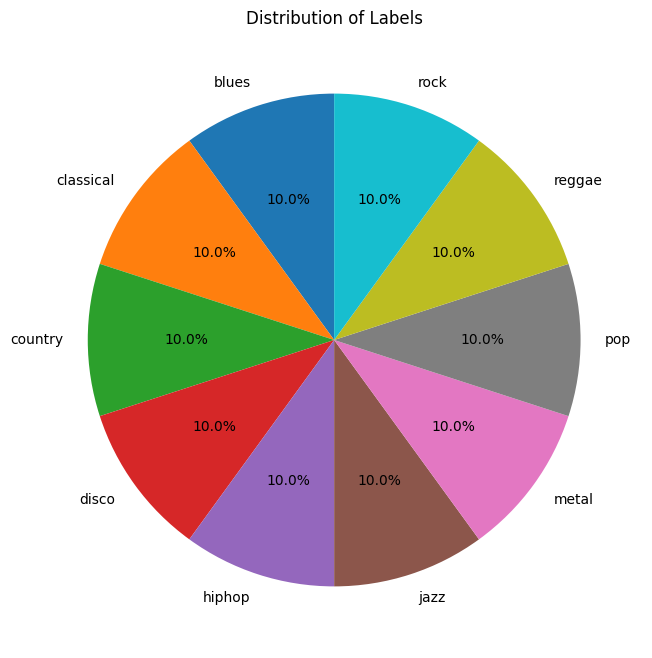

In [6]:
value_counts = metadata['label'].value_counts()
labels = value_counts.index
sizes = value_counts.values
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Labels")
plt.show()

In [7]:
# Add channel dimension for CNN: (samples, height, width, channels)
if len(X.shape) == 3:
  X = X[..., np.newaxis]
X.shape

(18023, 130, 40, 1)

In [8]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape
from tensorflow.keras.models import Model

def build_edl_model(input_shape, num_classes):
  inputs = Input(shape=(130, 40, 1))
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Reshape((x.shape[1], -1))(x)  # Flatten spatial dims, keep time
  x = LSTM(64)(x)
  x = Dropout(0.5)(x)
  evidence = Dense(num_classes, activation='softplus')(x)
  return Model(inputs, outputs=evidence)

In [9]:
import tensorflow as tf
import numpy as np

def kl_dirichlet(alpha, num_classes):
    # alpha shape: (batch, num_classes)
    beta = tf.ones([1, num_classes], dtype=tf.float32)  # prior Dirichlet
    S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
    S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)

    lnB_alpha = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
    lnB_beta = tf.math.lgamma(S_beta) - tf.reduce_sum(tf.math.lgamma(beta), axis=1, keepdims=True)

    digamma_alpha = tf.math.digamma(alpha)
    digamma_S_alpha = tf.math.digamma(S_alpha)

    kl = tf.reduce_sum((alpha - beta) * (digamma_alpha - digamma_S_alpha), axis=1, keepdims=True) + lnB_alpha - lnB_beta
    return kl  # shape (batch, 1)

def edl_loss(true, evidence, coeff=1.0):
    if len(true.shape) > 1 and true.shape[1] > 1:
        true = tf.argmax(true, axis=1)
    true = tf.cast(true, tf.int32)
    epsilon = 1e-8
    # Use standard alpha = evidence + 1
    alpha = evidence + 1.0
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    true_one_hot = tf.one_hot(true, depth=alpha.shape[1])
    loglikelihood = tf.reduce_sum(
        true_one_hot * (tf.math.log(alpha + epsilon) - tf.math.log(S + epsilon)), axis=1
    )
    kld = kl_dirichlet(alpha, num_classes=alpha.shape[1])
    return tf.reduce_mean(-loglikelihood + coeff * kld)

def edl_accuracy(y_true, evidence):
    if len(y_true.shape) > 1:
        y_true = tf.argmax(y_true, axis=1)
    alpha = evidence + 1
    probs = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)
    preds = tf.argmax(probs, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, tf.cast(y_true, tf.int64)), tf.float32))

# Make sure your labels are integer encoded, not one-hot
print("Sample y_train before split:", y_encoded)

Sample y_train before split: [0 0 0 ... 9 9 9]


In [15]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

input_shape = X_train.shape[1:]
num_classes = len(genres)

model = build_edl_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss=lambda y, ev: edl_loss(y, ev, coeff=1e-2),
    metrics=[edl_accuracy]
)
model.summary()

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 130, 40, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 130, 40, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 65, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 65, 640)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │       180,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,450 (708.79 KB)

 Trainable params: 181,450 (708.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 77s 205ms/step - edl_accuracy: 0.2284 - loss: 2.1945 - val_edl_accuracy: 0.3698 - val_loss: 2.0161
Epoch 2/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 77s 213ms/step - edl_accuracy: 0.3401 - loss: 2.0303 - val_edl_accuracy: 0.4262 - val_loss: 1.9147
Epoch 3/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 75s 208ms/step - edl_accuracy: 0.3763 - loss: 1.9442 - val_edl_accuracy: 0.4791 - val_loss: 1.8429
Epoch 4/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 74s 204ms/step - edl_accuracy: 0.4080 - loss: 1.8859 - val_edl_accuracy: 0.4904 - val_loss: 1.7983
Epoch 5/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - edl_accuracy: 0.4180 - loss: 1.8369 - val_edl_accuracy: 0.5076 - val_loss: 1.7504
Epoch 6/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 75s 208ms/step - edl_accuracy: 0.4364 - loss: 1.7970 - val_edl_accuracy: 0.5426 - val_loss: 1.7044
Epoch 7/40
361/361 ━━━━━━━━━━━━━━━━━━━━ 75s 207ms/step - edl_accuracy: 0.4502 - loss: 1.7581 - val_edl_accuracy: 0.5295 - val_loss: 1.6669
Epoch 8/40
361/361 ━━━━━━━━

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step


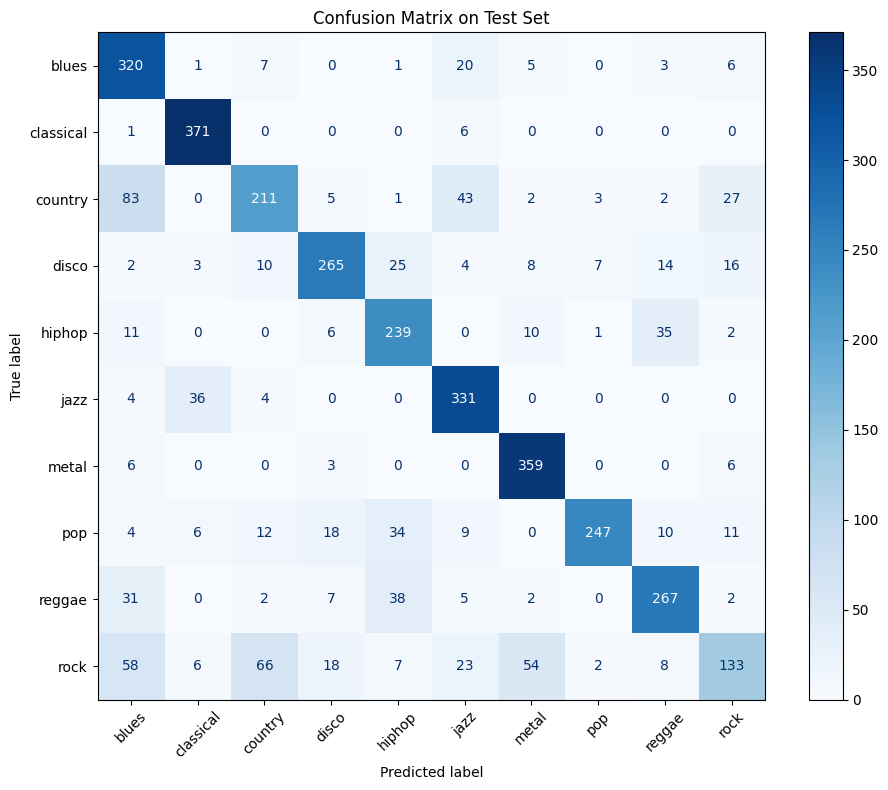

Classification Report:

              precision    recall  f1-score   support

       blues       0.62      0.88      0.72       363
   classical       0.88      0.98      0.93       378
     country       0.68      0.56      0.61       377
       disco       0.82      0.75      0.78       354
      hiphop       0.69      0.79      0.74       304
        jazz       0.75      0.88      0.81       375
       metal       0.82      0.96      0.88       374
         pop       0.95      0.70      0.81       351
      reggae       0.79      0.75      0.77       354
        rock       0.66      0.35      0.46       375

    accuracy                           0.76      3605
   macro avg       0.76      0.76      0.75      3605
weighted avg       0.76      0.76      0.75      3605



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get model predictions
y_pred_evidence = model.predict(X_test)
y_pred = np.argmax(y_pred_evidence, axis=1)
y_true = y_test

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

report = classification_report(y_true, y_pred, target_names=genres)
print("Classification Report:\n")
print(report)

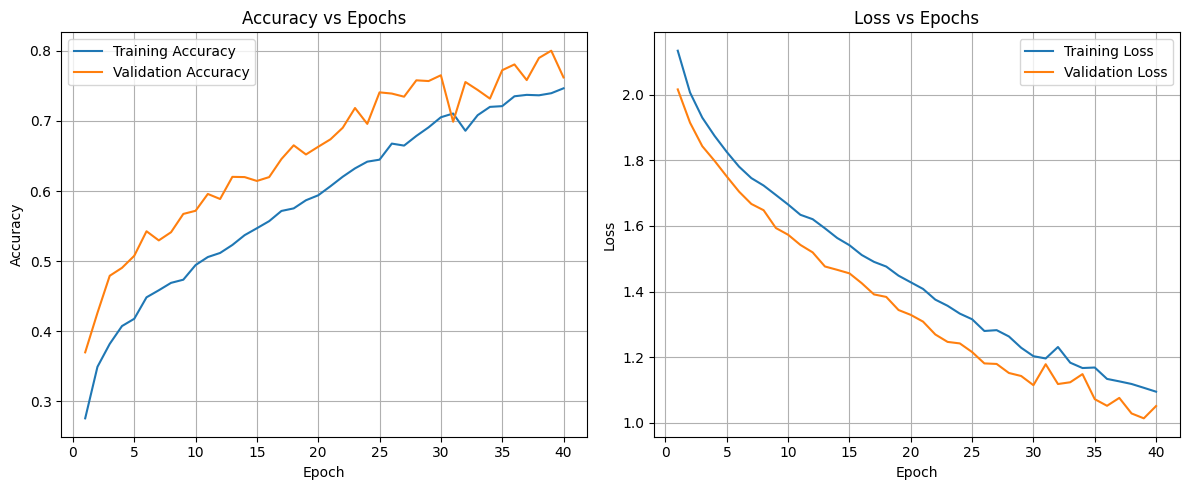

In [17]:
import matplotlib.pyplot as plt

# Extract metrics
acc = history.history['edl_accuracy']
val_acc = history.history['val_edl_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
import numpy as np

def compute_uncertainty(evidence):
    """
    Compute uncertainty from Dirichlet evidence using a small prior.
    evidence: array of shape (num_samples, num_classes)
    Returns: uncertainty score for each sample
    """
    alpha = evidence + 1
    S = np.sum(alpha, axis=1, keepdims=True)
    uncertainty = len(alpha[0]) / S  # Higher means more uncertainty
    return uncertainty.flatten()

In [47]:
# Predict evidence
evidence = model.predict(X_test)

# Compute uncertainty
uncertainty_scores = compute_uncertainty(evidence)

# Show uncertainty for first 10 test samples
for i in range(10):
    print(f"Sample {i+1} — Uncertainty: {uncertainty_scores[i]:.4f}, True Label: {label_encoder.inverse_transform([y_test[i]])[0]}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step
Sample 1 — Uncertainty: 0.4436, True Label: disco
Sample 2 — Uncertainty: 0.3252, True Label: country
Sample 3 — Uncertainty: 0.3421, True Label: pop
Sample 4 — Uncertainty: 0.3930, True Label: rock
Sample 5 — Uncertainty: 0.3524, True Label: jazz
Sample 6 — Uncertainty: 0.3882, True Label: country
Sample 7 — Uncertainty: 0.2913, True Label: metal
Sample 8 — Uncertainty: 0.3876, True Label: blues
Sample 9 — Uncertainty: 0.3117, True Label: hiphop
Sample 10 — Uncertainty: 0.3037, True Label: metal


In [48]:
threshold = 0.4

# Predicted classes
predicted_classes = np.argmax(evidence, axis=1)

# Check which predictions are correct
correct_mask = predicted_classes == y_test

# Flag reliable predictions: correct AND below threshold
reliable_mask = (uncertainty_scores <= threshold) & correct_mask
unreliable_mask = ~reliable_mask

# Print some flagged examples
for i in range(10):
    status = "UNRELIABLE" if unreliable_mask[i] else "reliable"
    print(f"Sample {i+1} — Uncertainty: {uncertainty_scores[i]:.4f}, "
          f"True Label: {label_encoder.inverse_transform([y_test[i]])[0]}, "
          f"Prediction: {label_encoder.inverse_transform([predicted_classes[i]])[0]} — {status}")

Sample 1 — Uncertainty: 0.4436, True Label: disco, Prediction: disco — UNRELIABLE
Sample 2 — Uncertainty: 0.3252, True Label: country, Prediction: country — reliable
Sample 3 — Uncertainty: 0.3421, True Label: pop, Prediction: pop — reliable
Sample 4 — Uncertainty: 0.3930, True Label: rock, Prediction: metal — UNRELIABLE
Sample 5 — Uncertainty: 0.3524, True Label: jazz, Prediction: jazz — reliable
Sample 6 — Uncertainty: 0.3882, True Label: country, Prediction: country — reliable
Sample 7 — Uncertainty: 0.2913, True Label: metal, Prediction: metal — reliable
Sample 8 — Uncertainty: 0.3876, True Label: blues, Prediction: blues — reliable
Sample 9 — Uncertainty: 0.3117, True Label: hiphop, Prediction: reggae — UNRELIABLE
Sample 10 — Uncertainty: 0.3037, True Label: metal, Prediction: metal — reliable


In [49]:
from collections import defaultdict

# Dictionary to store uncertainties per class
class_uncertainties = defaultdict(list)

# Group uncertainties by true label
for i, label in enumerate(y_test):
    class_uncertainties[label].append(uncertainty_scores[i])

# Calculate and print average uncertainty for each class
print("\nAverage uncertainty per class:")
for label in sorted(class_uncertainties.keys()):
    avg_uncertainty = np.mean(class_uncertainties[label])
    class_name = label_encoder.inverse_transform([label])[0]
    print(f"{class_name}: {avg_uncertainty:.4f}")


Average uncertainty per class:
blues: 0.3904
classical: 0.2855
country: 0.3632
disco: 0.4421
hiphop: 0.3726
jazz: 0.3747
metal: 0.2993
pop: 0.3468
reggae: 0.3832
rock: 0.4000


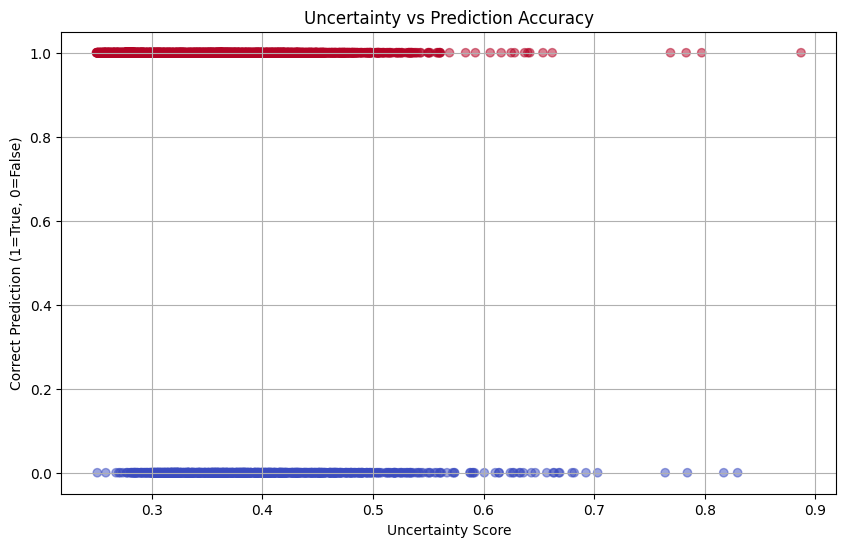

In [50]:
import matplotlib.pyplot as plt

# Accuracy per sample
correct_predictions = (predicted_classes == y_test)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(uncertainty_scores, correct_predictions, alpha=0.5, c=correct_predictions, cmap='coolwarm')
plt.xlabel("Uncertainty Score")
plt.ylabel("Correct Prediction (1=True, 0=False)")
plt.title("Uncertainty vs Prediction Accuracy")
plt.grid(True)
plt.show()

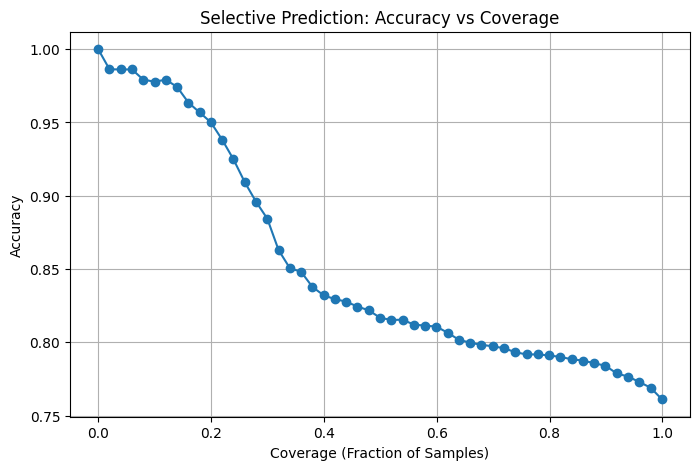

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Sort by confidence (i.e., low uncertainty)
sorted_indices = np.argsort(uncertainty_scores)
sorted_uncertainty = uncertainty_scores[sorted_indices]
sorted_preds = predicted_classes[sorted_indices]
sorted_true = y_test[sorted_indices]

# Track coverage (fraction of data retained) and accuracy
coverages = []
accuracies = []

total = len(y_test)

# Iterate over thresholds (from most confident to all)
for k in range(1, total + 1, total // 50):  # 50 points
    selected_preds = sorted_preds[:k]
    selected_true = sorted_true[:k]

    accuracy = np.mean(selected_preds == selected_true)
    coverage = k / total

    coverages.append(coverage)
    accuracies.append(accuracy)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(coverages, accuracies, marker='o')
plt.title("Selective Prediction: Accuracy vs Coverage")
plt.xlabel("Coverage (Fraction of Samples)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [52]:
def compute_ece(probs, labels, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(np.max(probs, axis=1), bins) - 1
    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.sum(bin_mask) > 0:
            bin_accuracy = np.mean(np.argmax(probs[bin_mask], axis=1) == labels[bin_mask])
            bin_confidence = np.mean(np.max(probs[bin_mask], axis=1))
            ece += (np.sum(bin_mask) / len(labels)) * np.abs(bin_accuracy - bin_confidence)
    return ece

# Convert Dirichlet alpha to probs
alpha = evidence + 1
probs = alpha / np.sum(alpha, axis=1, keepdims=True)
ece_score = compute_ece(probs, y_test)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

Expected Calibration Error (ECE): 0.2518


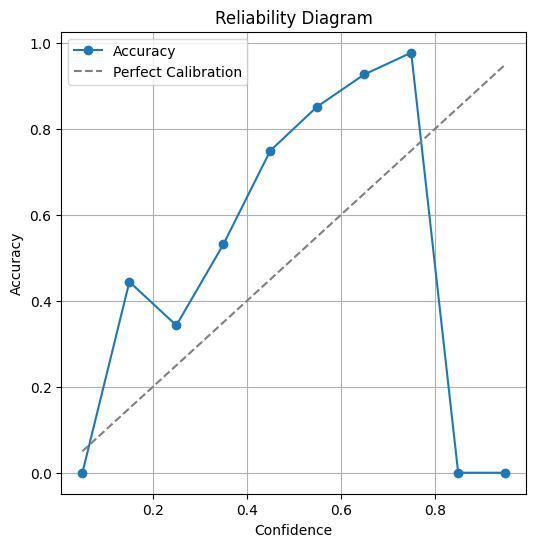

In [53]:
def plot_reliability_diagram(probs, labels, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    accuracies = []
    confidences = []
    bin_centers = (bins[:-1] + bins[1:]) / 2

    for i in range(n_bins):
        mask = (np.max(probs, axis=1) > bins[i]) & (np.max(probs, axis=1) <= bins[i+1])
        if np.any(mask):
            acc = np.mean(np.argmax(probs[mask], axis=1) == labels[mask])
            conf = np.mean(np.max(probs[mask], axis=1))
            accuracies.append(acc)
            confidences.append(conf)
        else:
            accuracies.append(0)
            confidences.append(0)

    plt.figure(figsize=(6, 6))
    plt.plot(bin_centers, accuracies, marker='o', label="Accuracy")
    plt.plot(bin_centers, bin_centers, linestyle='--', color='gray', label="Perfect Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_reliability_diagram(probs, y_test)

91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
Optimal temperature (ECE-based): 0.5397
Expected Calibration Error (ECE) after temperature scaling: 0.0135


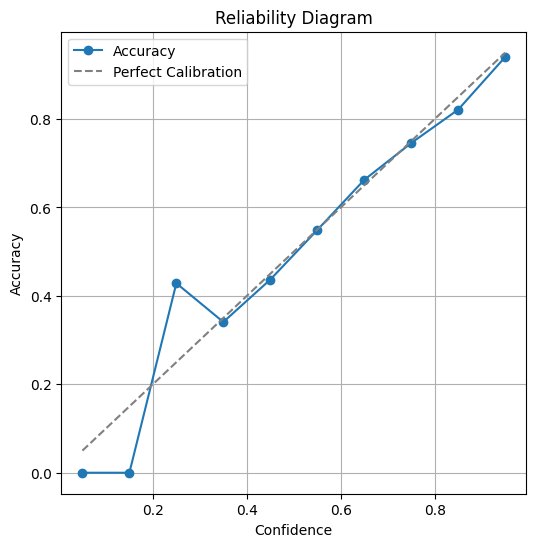

In [54]:
val_evidence = model.predict(X_val)
val_probs = val_evidence + 1
val_probs /= np.sum(val_probs, axis=1, keepdims=True)

def temperature_scale(probs, temperature):
    logits = np.log(probs + 1e-12)
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
from scipy.optimize import minimize_scalar

def ece_loss(temp, val_probs, val_labels):
    scaled_probs = temperature_scale(val_probs, temp)
    return compute_ece(scaled_probs, val_labels)
res = minimize_scalar(
    lambda t: ece_loss(t, val_probs, y_val),
    bounds=(0.5, 5.0),
    method='bounded'
)

optimal_temp = res.x
print(f"Optimal temperature (ECE-based): {optimal_temp:.4f}")
test_calibrated_probs = temperature_scale(probs, optimal_temp)
ece_score_calibrated = compute_ece(test_calibrated_probs, y_test)
print(f"Expected Calibration Error (ECE) after temperature scaling: {ece_score_calibrated:.4f}")
plot_reliability_diagram(test_calibrated_probs, y_test)


In [55]:
calibrated_uncertainty_scores = 1 - np.max(test_calibrated_probs, axis=1)
threshold = 0.4
predicted_classes = np.argmax(evidence, axis=1)

# Compare predictions with true labels
correct_mask = predicted_classes == y_test

# Reliable = correct prediction AND uncertainty below threshold
reliable_mask = (calibrated_uncertainty_scores <= threshold) & correct_mask
unreliable_mask = ~reliable_mask

# Print flagged examples
for i in range(10):
    status = "UNRELIABLE" if unreliable_mask[i] else "reliable"
    print(f"Sample {i+1} — Uncertainty: {calibrated_uncertainty_scores[i]:.4f}, "
          f"True Label: {label_encoder.inverse_transform([y_test[i]])[0]}, "
          f"Prediction: {label_encoder.inverse_transform([predicted_classes[i]])[0]} — {status}")

Sample 1 — Uncertainty: 0.3072, True Label: disco, Prediction: disco — reliable
Sample 2 — Uncertainty: 0.4986, True Label: country, Prediction: country — UNRELIABLE
Sample 3 — Uncertainty: 0.1350, True Label: pop, Prediction: pop — reliable
Sample 4 — Uncertainty: 0.1185, True Label: rock, Prediction: metal — UNRELIABLE
Sample 5 — Uncertainty: 0.0423, True Label: jazz, Prediction: jazz — reliable
Sample 6 — Uncertainty: 0.3832, True Label: country, Prediction: country — reliable
Sample 7 — Uncertainty: 0.0288, True Label: metal, Prediction: metal — reliable
Sample 8 — Uncertainty: 0.1454, True Label: blues, Prediction: blues — reliable
Sample 9 — Uncertainty: 0.3771, True Label: hiphop, Prediction: reggae — UNRELIABLE
Sample 10 — Uncertainty: 0.0361, True Label: metal, Prediction: metal — reliable


In [56]:
# Dictionary to store calibrated uncertainties per class
class_uncertainties_calibrated = defaultdict(list)

    # Group uncertainties by true label using calibrated scores
for i, label in enumerate(y_test):
        class_uncertainties_calibrated[label].append(calibrated_uncertainty_scores[i])

print("\nAverage calibrated uncertainty per class:")
for label in sorted(class_uncertainties_calibrated.keys()):
          avg_uncertainty_calibrated = np.mean(class_uncertainties_calibrated[label])
          class_name = label_encoder.inverse_transform([label])[0]
          print(f"{class_name}: {avg_uncertainty_calibrated:.4f}")


Average calibrated uncertainty per class:
blues: 0.2755
classical: 0.0609
country: 0.4243
disco: 0.2105
hiphop: 0.2828
jazz: 0.1266
metal: 0.0609
pop: 0.1892
reggae: 0.2974
rock: 0.3768


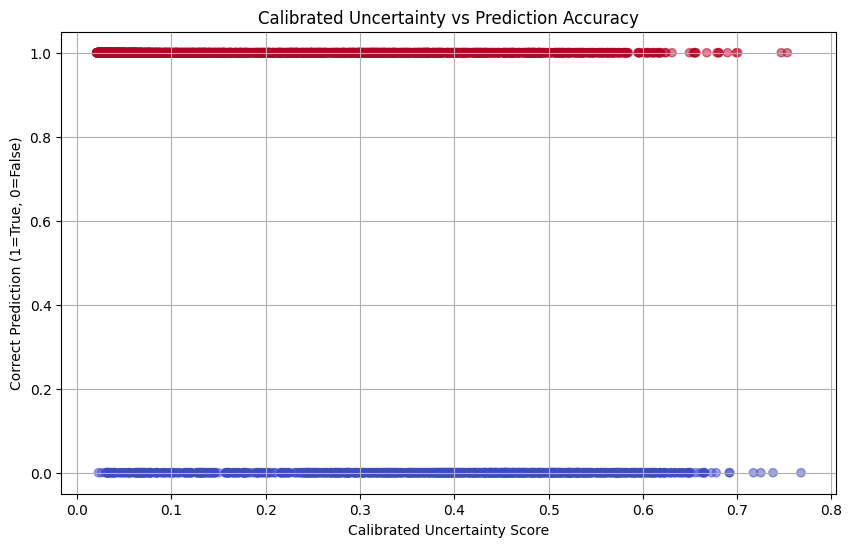

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(calibrated_uncertainty_scores, correct_predictions, alpha=0.5, c=correct_predictions, cmap='coolwarm')
plt.xlabel("Calibrated Uncertainty Score")
plt.ylabel("Correct Prediction (1=True, 0=False)")
plt.title("Calibrated Uncertainty vs Prediction Accuracy")
plt.grid(True)
plt.show()

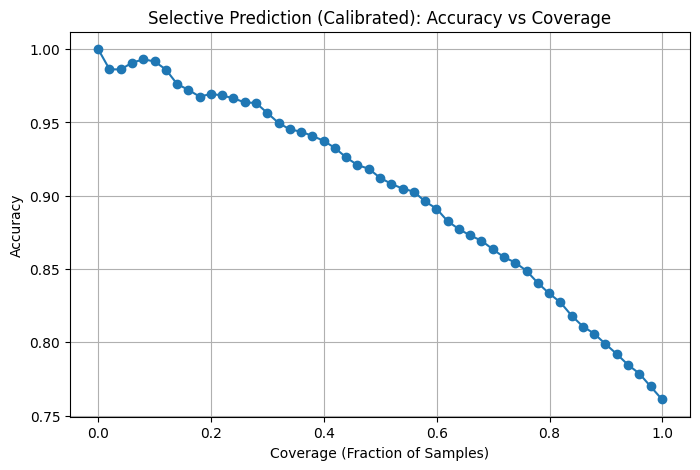

In [58]:
# Sort by confidence (i.e., low calibrated uncertainty)
sorted_indices_calibrated = np.argsort(calibrated_uncertainty_scores)
sorted_uncertainty_calibrated = calibrated_uncertainty_scores[sorted_indices_calibrated]
sorted_preds_calibrated = predicted_classes[sorted_indices_calibrated]
sorted_true_calibrated = y_test[sorted_indices_calibrated]

# Track coverage (fraction of data retained) and accuracy
coverages_calibrated = []
accuracies_calibrated = []
total = len(y_test)

# Iterate over thresholds (from most confident to all)
for k in range(1, total + 1, total // 50):  # 50 points
        selected_preds_calibrated = sorted_preds_calibrated[:k]
        selected_true_calibrated = sorted_true_calibrated[:k]

        accuracy_calibrated = np.mean(selected_preds_calibrated == selected_true_calibrated)
        coverage_calibrated = k / total

        coverages_calibrated.append(coverage_calibrated)
        accuracies_calibrated.append(accuracy_calibrated)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(coverages_calibrated, accuracies_calibrated, marker='o')
plt.title("Selective Prediction (Calibrated): Accuracy vs Coverage")
plt.xlabel("Coverage (Fraction of Samples)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [61]:
from scipy.stats import wilcoxon

ece_before = compute_ece(probs, y_test, n_bins=10)
ece_after  = compute_ece(test_calibrated_probs, y_test, n_bins=10)

print(f"ECE before calibration: {ece_before:.6f}")
print(f"ECE after calibration:  {ece_after:.6f}")

# Bootstrap for CI of difference
n_bootstrap = 1000
rng = np.random.default_rng(12345)
N = len(y_test)
diffs = []

for _ in range(n_bootstrap):
    idx = rng.integers(0, N, size=N)
    ece_b = compute_ece(probs[idx], y_test[idx], n_bins=10)
    ece_a = compute_ece(test_calibrated_probs[idx], y_test[idx], n_bins=10)
    diffs.append(ece_b - ece_a)

diffs = np.array(diffs)
ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
print(f"Mean difference (before - after): {diffs.mean():.6f}")
print(f"95% bootstrap CI: [{ci_lower:.6f}, {ci_upper:.6f}]")
print(f"Proportion of bootstrap samples with ECE_before > ECE_after: {(diffs > 0).mean():.3f}")

# Wilcoxon test
w_stat, w_p = wilcoxon(diffs)
print(f"Wilcoxon statistic = {w_stat:.4f}, p-value = {w_p:.6e}")

if w_p < 0.05:
    print("Wilcoxon: significant reduction in ECE after calibration")
else:
    print("Wilcoxon: no significant change in ECE")

ECE before calibration: 0.251769
ECE after calibration:  0.013528
Mean difference (before - after): 0.231760
95% bootstrap CI: [0.212078, 0.248808]
Proportion of bootstrap samples with ECE_before > ECE_after: 1.000
Wilcoxon statistic = 0.0000, p-value = 3.325859e-165
Wilcoxon: significant reduction in ECE after calibration
